# Ultimate Challange
# Part 1 - Exploratory Data Analysis

In [119]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [80]:
#what are the files in the dir?
!ls

GH_ultimate_challange_takehome.ipynb ultimate_data_challenge.json
Untitled.ipynb                       ultimate_data_science_challenge.pdf
logins.json


In [81]:
#create df using read_json, convert date to datetime format
logins_df = pd.read_json('logins.json', convert_dates=True)


In [82]:
logins_df.head() 

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


I assume these dates are wrong (considering they are close to Epoch). This presents a problem as to knowing when these data actually were generated.

Add a count column containing a 1 to record each instance, then set login_time column to index. Will then be able to use the resample function to group into 15 min intervals and apply .count() to record the number of entries in each interval.


In [83]:
#create the new count column
logins_df['count'] = int(1)
#convert datetime column to index
logins_df = logins_df.set_index('login_time')

In [84]:
#resample and count
logins_df = logins_df.resample('15T').count()
#check it out
logins_df.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


Even though it is clear the dates are incorrect, it may  be helpful to group by day of the week, so put those in as well.

In [93]:
#use strftime to pull days of week from the datetime 
logins_df['day_of_week'] = logins_df.index.strftime('%a')
logins_df.head()

,count,day_of_week
login_time,,
1970-01-01 20:00:00,2,Thu
1970-01-01 20:15:00,6,Thu
1970-01-01 20:30:00,9,Thu
1970-01-01 20:45:00,7,Thu
1970-01-01 21:00:00,1,Thu


In [167]:
#Summary statistics per 15 minute count
logins_df.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


In [169]:
#How many periods have 0 logins:
zero_values = logins_df[logins_df['count'] == 0]
zero_values.count()
#zero_values.head(20)

count          407
day_of_week    407
dtype: int64

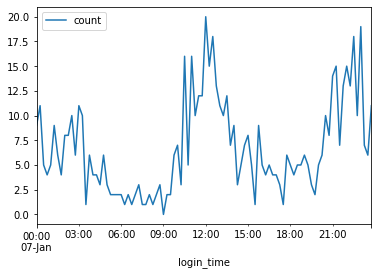

In [109]:
#visualize the data. The first y of data 01-01 begins at 8pm, so look at day 2.
logins_df.loc['1970-01-07'].plot()

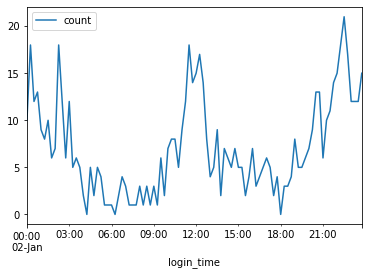

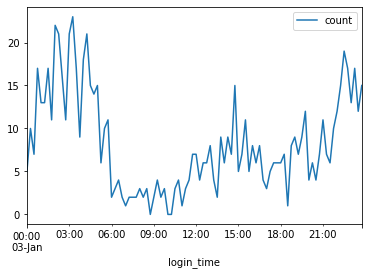

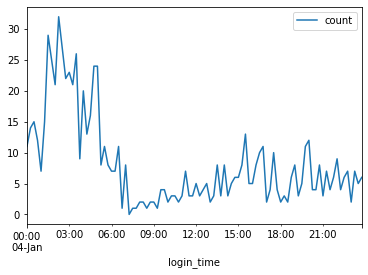

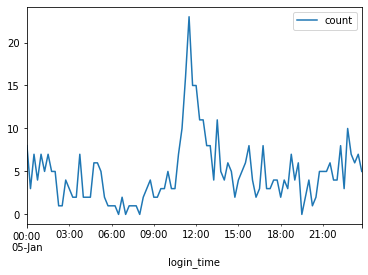

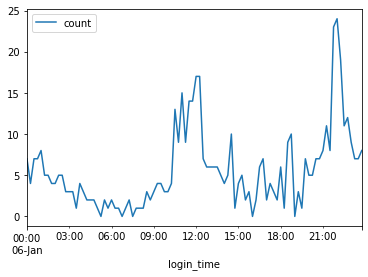

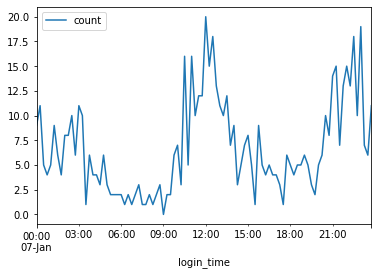

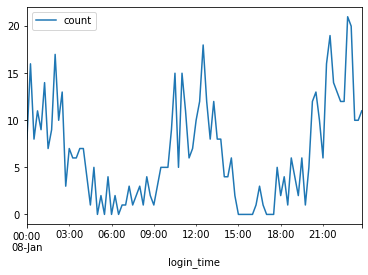

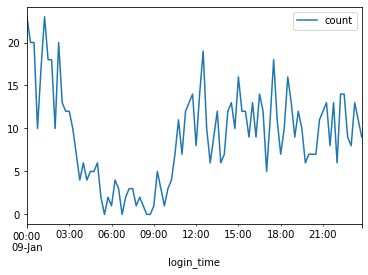

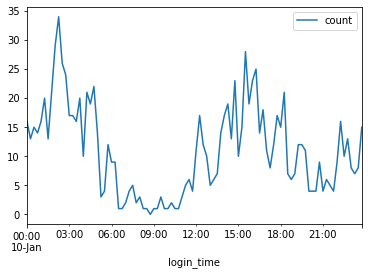

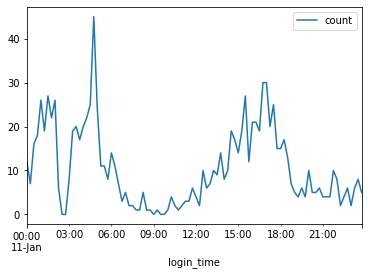

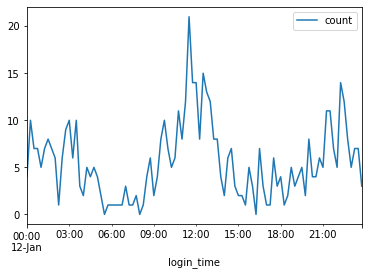

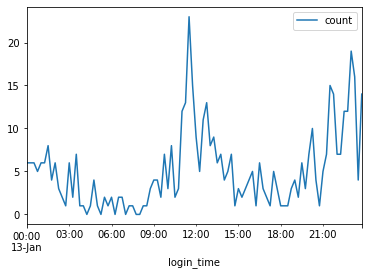

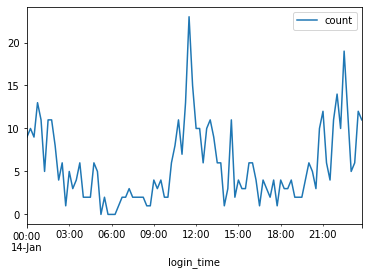

In [124]:
#Look over the course of a week
for i in range(2,15,1):
    _ = logins_df.loc['1970-01-'+str(i)].plot()

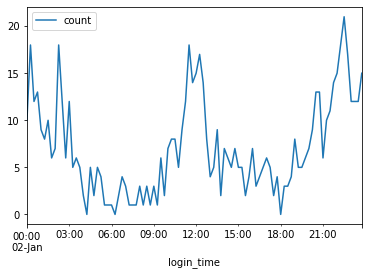

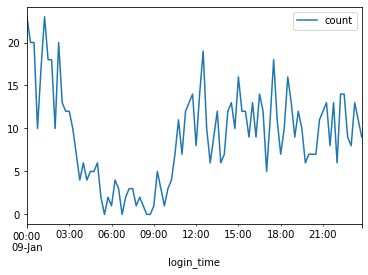

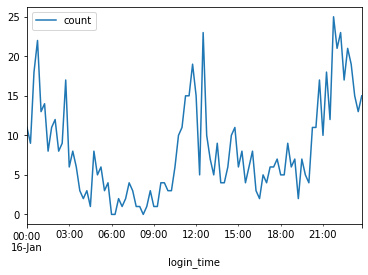

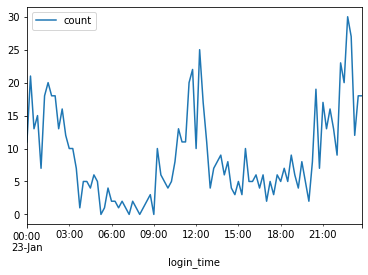

In [132]:
#let's look at every monday in the first month
for i in range(2,28,7):
    _ = logins_df.loc['1970-01-' + str(i)].plot()

In [134]:
#Find time span for these data:
begin = logins_df.index.date.min()
end = logins_df.index.date.max()
print(f'The date range of this dataset is from {begin} to {end}')


The date range of this dataset is from 1970-01-01 to 1970-04-13


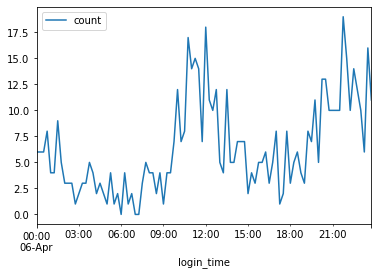

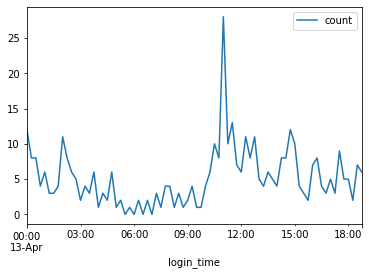

In [140]:
#Let's look at the last few Mondays in april
logins_df.loc['1970-04-6'].plot()
logins_df.loc['1970-04-13'].plot()

## Summary
Despite the date being wrong, the days of the week appear to be set correctly based on the observed login patterns. There is a pattern for weekdays to have a peak login around midnight and midday, with the lowest logins around 6am and 6pm. For the weekends, the busiest time appears to be in the early hours of the morning. There are 407 periods with no counts, but upon inspection these do not seem to follow a pattern.

# Part 2 - Experiment and Metrics Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.



### 1. 
I would request that pickup and dropoff location were recorded. This would reveal if driver partners were servicing both cities, and the frequency at which they do it. This could be tracked with pickup location alone, however with dropoff location, it can be tracked whether drivers pickup in the other city because they had a dropoff, or whether they travel there to pick up the ride. A key measure of success would be identifying a subset of the drivers who are based close to each side of the bridge, and observing  both pickups and dropoffs logged for each city. Assessing all drivers may result in loss of the signal, as it is assumed that there is some 'home territory' that many drivers adhere to - expecially in extreme ends of the cities away from the bridge.

### 2.
### a.
The practical experiment I would perform would be A/B testing. I would chose this because it is a simple and effective way to test whether the proposal to reimburse all toll costs restuls in more cross-city traffic. Driver partners would be selected as having 'home territory' close to the toll bridge. These groups would then be randomly divided into two groups - a control group that does not recieve reimbursement, and a test group that does recieve reimbursement. I would also run this experiment on the weekend, where there is 'reasonable activity in both cities'. 

Running the experiment during the week risks a type II error. A negative result may be obtained, not because the reimbursement of tolls doesn't work, but because drivers may only work one shift a day. If so, a driver would chose to to drive either in the day or night, which would limit them to one side of the city, because there would be less business in the other side.


### b.
The hypotheses for this expeiment are:

H0 - That reimbursement of tolls does not affect the availability of driver partners in both cities

H1 - That reimbursement of tolls does affect the availability of driver partners in both cities


Data would be recorded for pickup location and dropoff location for each driver, and the two groups then compared. To analyze the data, a simple t-test could be used to see if the distribution of cross-city pckups is significantly different for drivers who were reimbursed for tolls (test group) than those who were not reimbursed (control group).

### c.
Significance between the groups would indicate that reimburing tolls does lead to greater availability of individual drivers in both cities. A caveat is that the experiment may have to be run over several weekends, in different times of the year. Factors that could influence cross-city traffic could include  festivals or events in one city, or summer holidays where there are more tourists who may influence to usual cross-city traffic.